In [535]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [536]:
df = pd.read_csv(
    "v-sales-data.csv",
)

In [537]:
df['Market Category']=df.groupby(by=["Make"])['Market Category'].apply(lambda x:x.fillna(x.mode().iloc[0])).sort_index(level=1).reset_index(drop=True)

In [538]:
twentieth_century_df = df.loc[df["Year"] > 1999].copy(deep=True)

In [539]:
def regression_combine_test(y_true,y_pred):
    mse=mean_squared_error(y_true, y_pred)
    mae=mean_absolute_error(y_true, y_pred)
    rmse=root_mean_squared_error(y_true, y_pred)
    r2=r2_score(y_true, y_pred)
    return [mse,mae,rmse,r2]

In [540]:
X=twentieth_century_df.drop(columns=['MSRP']).bfill()
y=twentieth_century_df['MSRP'].loc[X.index]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True)

In [541]:
from sklearn import preprocessing
def encode_features(df_train, df_test,features):
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(X_train, X_test,features = ['Make','Model' ,'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels','Vehicle Size','Vehicle Style','Market Category'])

In [542]:
data_train

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
1529,8,60,2015,9,202.0,4.0,1,3,4.0,63,0,14,33,21,1624
3996,15,239,2006,9,291.0,6.0,1,1,4.0,41,1,3,18,13,549
11275,45,698,2013,9,181.0,4.0,1,0,4.0,0,2,15,26,20,2031
8356,14,558,2010,9,207.0,6.0,3,1,2.0,41,0,10,19,15,5657
5333,46,316,2009,7,200.0,4.0,0,2,4.0,69,0,14,29,22,873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,5,95,2010,8,500.0,8.0,1,3,2.0,32,1,6,15,9,520
1939,46,103,2016,7,210.0,4.0,3,2,2.0,60,0,0,31,23,873
10570,25,670,2010,4,239.0,8.0,1,3,4.0,45,1,14,24,16,61
4784,14,284,2015,4,160.0,4.0,0,2,4.0,55,0,2,40,27,5657


In [543]:
lin_reg=LinearRegression()
tree_reg=tree.DecisionTreeRegressor()
forest_reg=RandomForestRegressor(n_estimators=100, random_state=42)
svm_reg=SVR()
lin_reg.fit(X_train,y_train)
tree_reg.fit(X_train,y_train)
forest_reg.fit(X_train,y_train.to_numpy(dtype='int64').ravel())
svm_reg.fit(X_train,y_train)

SVR()

In [544]:
y_lin_pred=lin_reg.predict(X_test)
y_tree_pred=tree_reg.predict(X_test)
y_forest_pred=forest_reg.predict(X_test)
y_svm_pred=svm_reg.predict(X_test)

In [545]:
evaluation_metrics=[regression_combine_test(y_test,y_lin_pred),regression_combine_test(y_test,y_tree_pred),regression_combine_test(y_test,y_forest_pred),regression_combine_test(y_test,y_svm_pred)]

In [546]:
data={'model':['LinearRegression', 'Tree', 'Forest','Svm'],'metrics':evaluation_metrics}
metrics= pd.DataFrame(data)
metrics_df = pd.DataFrame(metrics['metrics'].tolist(), columns=['MSE', 'MAE', 'RMSE', 'R2'])
metrics = pd.concat([metrics['model'], metrics_df], axis=1)
# metric=metrics.melt(id_vars=['model'],value_vars=['MSE','MAE','RMSE','R2'],var_name='metric')

In [547]:
metrics

,model,MSE,MAE,RMSE,R2
0,LinearRegression,1.606999e+09,20496.888807,40087.392508,0.527431
1,Tree,8.087959e+08,4488.428339,28439.337906,0.762158
2,Forest,9.673418e+07,3687.376875,9835.353779,0.971553
3,Svm,3.559333e+09,21877.757798,59660.147323,-0.046690


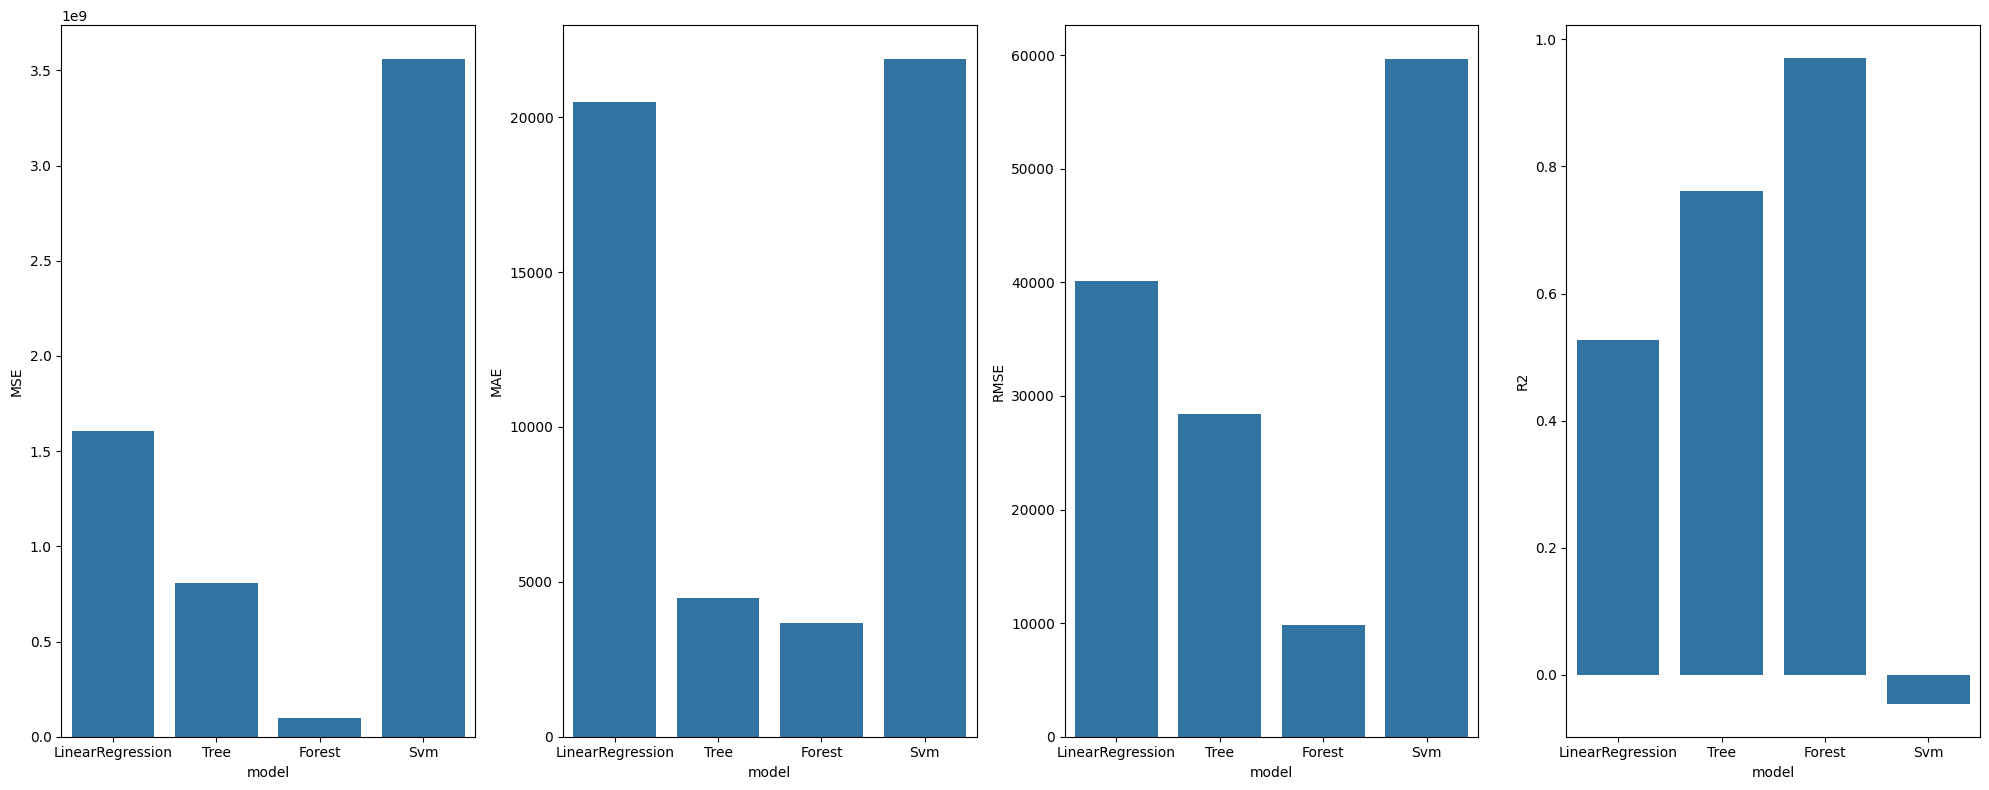

In [548]:

fig,axs=plt.subplots(ncols=4,figsize=(20,8))
sns.barplot(data=metrics,x='model',y='MSE',ax=axs[0])
sns.barplot(data=metrics,x='model',y='MAE',ax=axs[1])
sns.barplot(data=metrics,x='model',y='RMSE',ax=axs[2])
sns.barplot(data=metrics,x='model',y='R2',ax=axs[3])
plt.tight_layout()

In [549]:

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': tree.DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Svm':SVR()
}


scalers = {
    'Min-Max Scaler': MinMaxScaler(),
    'Standard Scaler': StandardScaler(),
    'Robust Scaler': RobustScaler()
}


metrics_scaled = {
    'Model': [],
    'Scaler': [],
    'MSE': [],
    'MAE': [],
    'RMSE': [],
    'R2': []
}


In [550]:
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for name, model in models.items():
        
            
        model.fit(X_train_scaled, y_train.to_numpy(dtype='int64').ravel()) if name=='Random Forest' else model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)
        
        metrics_scaled['Model'].append(name)
        metrics_scaled['Scaler'].append(scaler_name)
        metrics_scaled['MSE'].append(mse)
        metrics_scaled['MAE'].append(mae)
        metrics_scaled['RMSE'].append(rmse)
        metrics_scaled['R2'].append(r_squared)

pd.DataFrame(metrics_scaled).sort_values(by=['Model'])

,Model,Scaler,MSE,MAE,RMSE,R2
1,Decision Tree,Min-Max Scaler,8.082805e+08,4424.262785,28430.273822,0.762310
5,Decision Tree,Standard Scaler,8.058143e+08,4428.319463,28386.868382,0.763035
9,Decision Tree,Robust Scaler,2.275817e+08,3847.963146,15085.809911,0.933075
0,Linear Regression,Min-Max Scaler,1.606999e+09,20496.888807,40087.392508,0.527431
4,Linear Regression,Standard Scaler,1.606999e+09,20496.888807,40087.392508,0.527431
8,Linear Regression,Robust Scaler,1.606999e+09,20496.888807,40087.392508,0.527431
2,Random Forest,Min-Max Scaler,9.702652e+07,3687.448717,9850.203916,0.971468
6,Random Forest,Standard Scaler,9.662980e+07,3681.258473,9830.045537,0.971584
10,Random Forest,Robust Scaler,9.672030e+07,3691.734763,9834.647856,0.971558
3,Svm,Min-Max Scaler,3.554675e+09,21772.231871,59621.094100,-0.045320


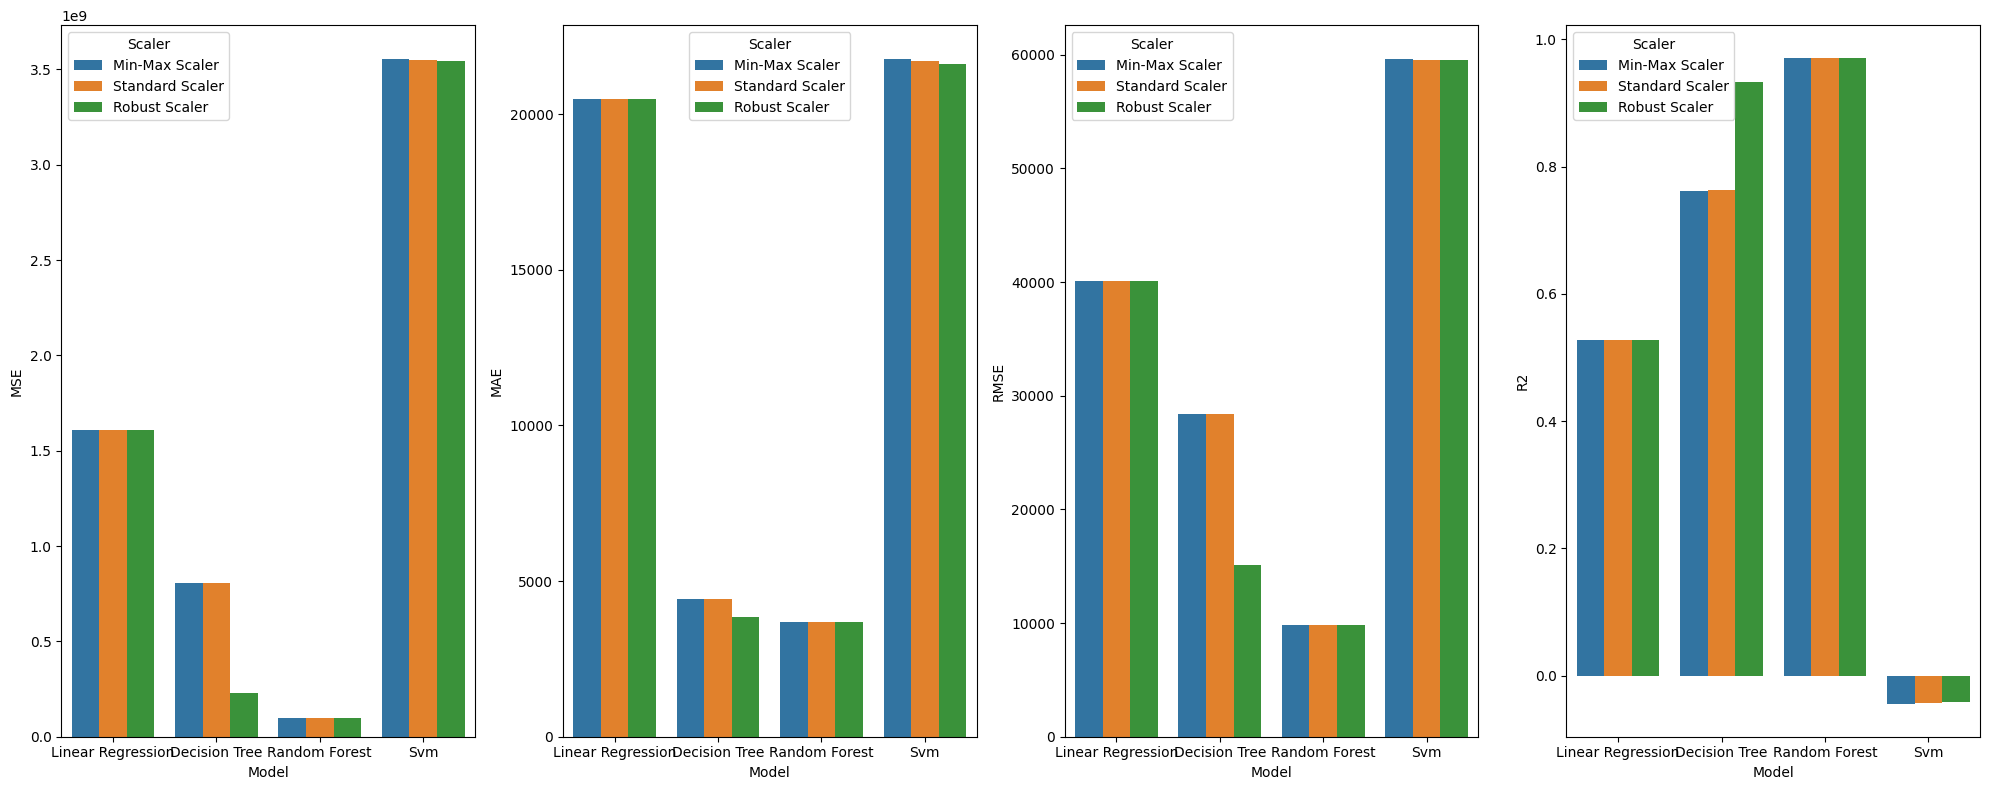

In [551]:

fig,axs=plt.subplots(ncols=4,figsize=(20,8))
sns.barplot(data=metrics_scaled,x='Model',y='MSE',ax=axs[0],hue='Scaler')
sns.barplot(data=metrics_scaled,x='Model',y='MAE',ax=axs[1],hue='Scaler')
sns.barplot(data=metrics_scaled,x='Model',y='RMSE',ax=axs[2],hue='Scaler')
sns.barplot(data=metrics_scaled,x='Model',y='R2',ax=axs[3],hue='Scaler')
plt.tight_layout()

In [552]:
twentieth_century_df['Engine Fuel Type'].value_counts()

Engine Fuel Type
regular unleaded                                5653
premium unleaded (required)                     2009
premium unleaded (recommended)                  1523
flex-fuel (unleaded/E85)                         888
diesel                                           145
electric                                          66
flex-fuel (premium unleaded required/E85)         54
flex-fuel (premium unleaded recommended/E85)      26
flex-fuel (unleaded/natural gas)                   6
natural gas                                        2
Name: count, dtype: int64

In [553]:
twentieth_century_df['Engine Fuel Type'].replace({'flex-fuel (premium unleaded required/E85)': 'flex-fuel',
                               'flex-fuel (premium unleaded recommended/E85)': 'flex-fuel', 'flex-fuel (unleaded/natural gas)': 'flex-fuel','flex-fuel (unleaded/E85)':'flex-fuel','natural gas':'flex-fuel','premium unleaded (required)':'unleaded','premium unleaded (recommended)':'unleaded','regular unleaded':'unleaded'},inplace=True)

/tmp/ipykernel_12943/4115559230.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  twentieth_century_df['Engine Fuel Type'].replace({'flex-fuel (premium unleaded required/E85)': 'flex-fuel',


In [554]:
enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

In [555]:
encoded=enc.fit_transform(pd.DataFrame(twentieth_century_df['Engine Fuel Type']))

In [556]:
enc.get_feature_names_out(['Engine Fuel Type'])


array(['Engine Fuel Type_diesel', 'Engine Fuel Type_electric',
       'Engine Fuel Type_flex-fuel', 'Engine Fuel Type_unleaded',
       'Engine Fuel Type_nan'], dtype=object)

In [557]:
one_hot_df=pd.DataFrame(encoded,columns=enc.get_feature_names_out(['Engine Fuel Type']))

In [558]:
one_hot_df

,Engine Fuel Type_diesel,Engine Fuel Type_electric,Engine Fuel Type_flex-fuel,Engine Fuel Type_unleaded,Engine Fuel Type_nan
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
10370,0.0,0.0,0.0,1.0,0.0
10371,0.0,0.0,0.0,1.0,0.0
10372,0.0,0.0,0.0,1.0,0.0
10373,0.0,0.0,0.0,1.0,0.0


In [559]:
df_encoded=pd.concat([df,one_hot_df],axis=1)

In [560]:
df_encoded.drop(columns=['Engine Fuel Type'],inplace=True)

In [561]:
y_encoded=df_encoded['MSRP']
X_encoded=df_encoded.drop(columns=['MSRP']).ffill()

In [562]:
X_train,X_test,y_train,y_test=train_test_split(X_encoded,y_encoded,test_size=0.2,shuffle=True)

In [563]:
data_train, data_test = encode_features(X_train, X_test,features = ['Make','Model', 'Transmission Type', 'Driven_Wheels','Vehicle Size','Vehicle Style','Market Category'])

In [564]:
data_train

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Engine Fuel Type_diesel,Engine Fuel Type_electric,Engine Fuel Type_flex-fuel,Engine Fuel Type_unleaded,Engine Fuel Type_nan
11732,8,884,2007,320.0,8.0,1,3,2.0,63,0,6,24,15,1624,0.0,0.0,0.0,1.0,0.0
1207,18,100,2015,196.0,4.0,1,2,4.0,62,2,14,45,50,2202,0.0,0.0,0.0,1.0,0.0
9775,9,764,2016,138.0,4.0,3,2,4.0,50,0,2,35,26,1385,0.0,0.0,0.0,1.0,0.0
11908,0,901,2011,300.0,6.0,1,0,4.0,13,2,2,23,16,204,0.0,0.0,0.0,1.0,0.0
8826,31,694,2016,621.0,12.0,1,3,2.0,38,1,8,20,13,617,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,47,701,2015,325.0,6.0,1,0,4.0,38,2,14,28,19,870,0.0,0.0,0.0,1.0,0.0
4237,43,324,2001,122.0,4.0,3,2,4.0,0,0,15,31,24,481,0.0,0.0,0.0,1.0,0.0
10949,45,830,2015,381.0,8.0,1,1,2.0,41,1,13,17,13,2031,0.0,0.0,0.0,1.0,0.0
581,12,37,2017,160.0,4.0,1,2,4.0,50,0,15,30,22,819,0.0,0.0,0.0,1.0,0.0


In [565]:
lin_reg=LinearRegression()
tree_reg=tree.DecisionTreeRegressor()
forest_reg=RandomForestRegressor(n_estimators=100, random_state=42)
svm_reg=SVR()
lin_reg.fit(data_train,y_train)
tree_reg.fit(data_train,y_train)
forest_reg.fit(data_train,y_train.to_numpy(dtype='int64').ravel())
svm_reg.fit(data_train,y_train)

SVR()

In [566]:
y_lin_pred=lin_reg.predict(X_test)
y_tree_pred=tree_reg.predict(X_test)
y_forest_pred=forest_reg.predict(X_test)
y_svm_pred=svm_reg.predict(X_test)

In [567]:
evaluation_metrics=[regression_combine_test(y_test,y_lin_pred),regression_combine_test(y_test,y_tree_pred),regression_combine_test(y_test,y_forest_pred),regression_combine_test(y_test,y_svm_pred)]

In [568]:
data={'model':['LinearRegression', 'Tree', 'Forest','Svm'],'metrics':evaluation_metrics}
metrics_encoded= pd.DataFrame(data)
metrics_df = pd.DataFrame(metrics_encoded['metrics'].tolist(), columns=['MSE', 'MAE', 'RMSE', 'R2'])
metrics_encoded = pd.concat([metrics_encoded['model'], metrics_df], axis=1)

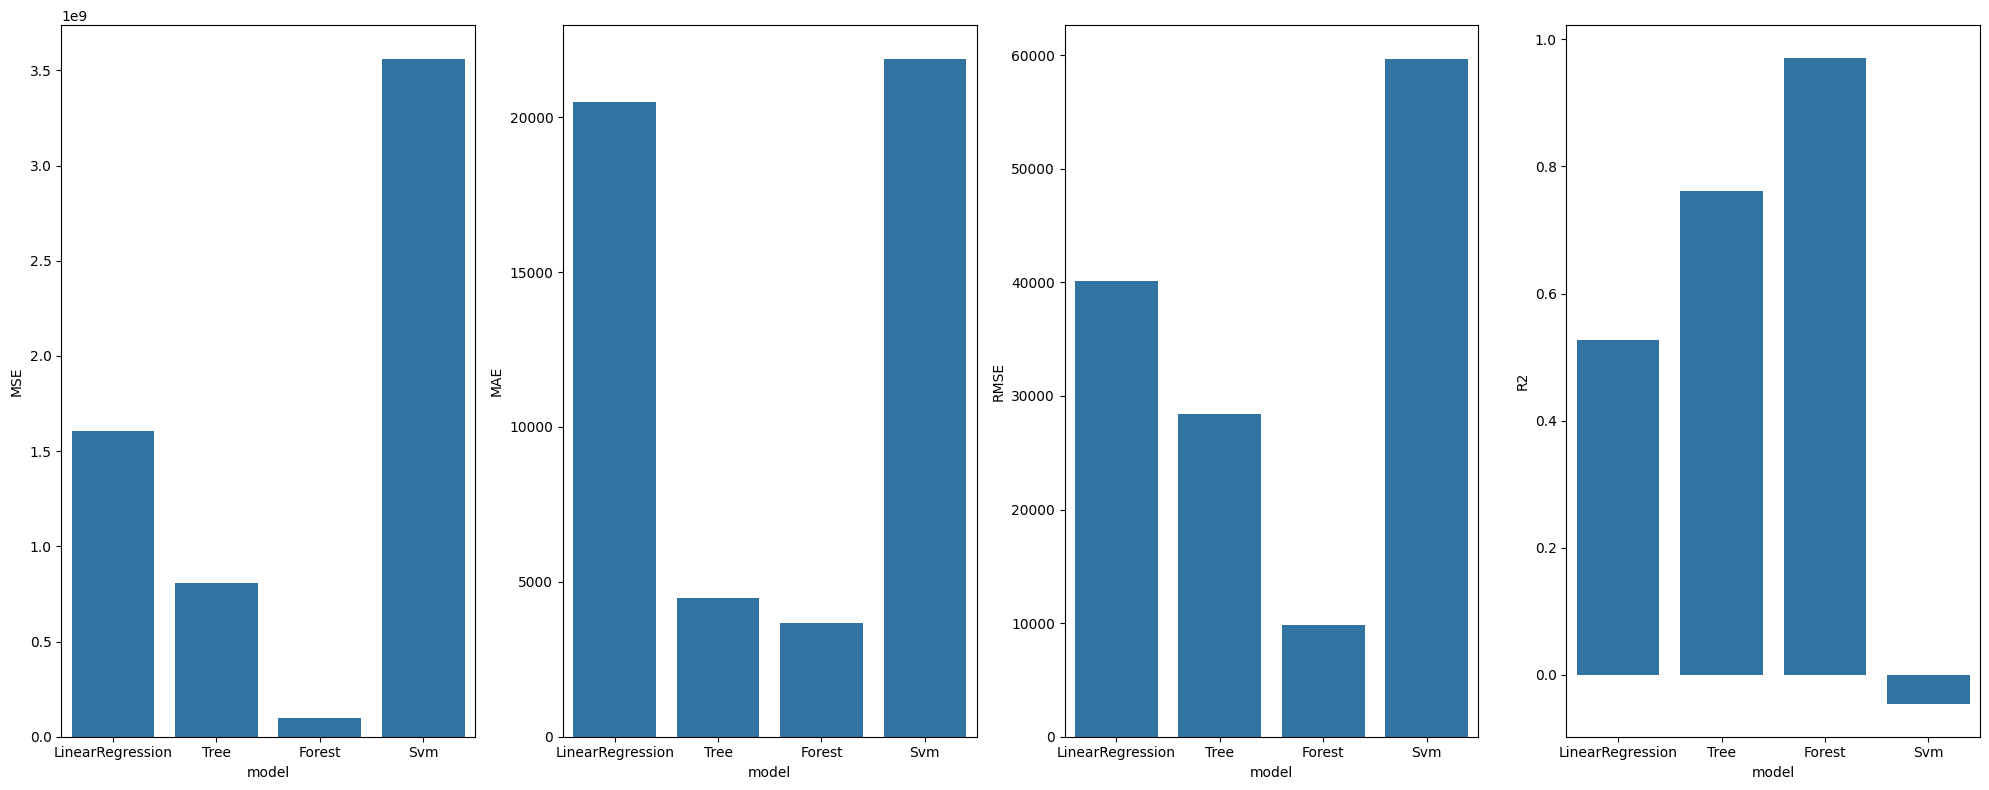

In [569]:

fig,axs=plt.subplots(ncols=4,figsize=(20,8))
sns.barplot(data=metrics,x='model',y='MSE',ax=axs[0])
sns.barplot(data=metrics,x='model',y='MAE',ax=axs[1])
sns.barplot(data=metrics,x='model',y='RMSE',ax=axs[2])
sns.barplot(data=metrics,x='model',y='R2',ax=axs[3])
plt.tight_layout()